# 1. How to costruct Quantum Circuit and run Simulation with Qiskit

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram, plot_distribution, plot_state_city
import qiskit.quantum_info as qi

plt.style.use('default')

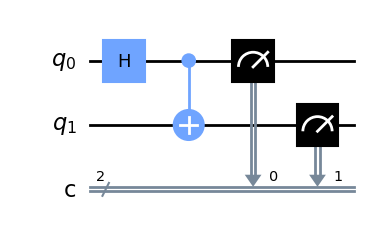

In [6]:
# Basic method to construct circuit and implement gates, measurement
# 2 qubit, 2 classical register circuit, Bell state 

circuit = QuantumCircuit(2,2)
circuit.h(0) # Hadamard gate on qubit 0
circuit.cx(0,1) # CNOT gate on control qubit 0,and target qubit 1
state = qi.Statevector.from_instruction(circuit) # Save statevector before measurement
circuit.measure([0,1],[0,1]) # Measurement
circuit.draw('mpl') # draw circuit using mpl style

In [7]:
# Lists of simulator from Aer
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

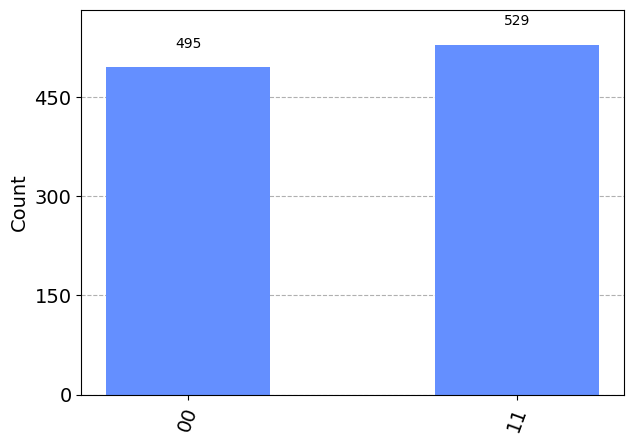

In [8]:
# Basic shot-based simulator, AerSimulator
simulator = Aer.get_backend('aer_simulator')
job = simulator.run(circuit, shots=1024)

plot_histogram(job.result().get_counts())

In [9]:
state.draw('latex', prefix='Statevector:') # Visualize statevector

<IPython.core.display.Latex object>

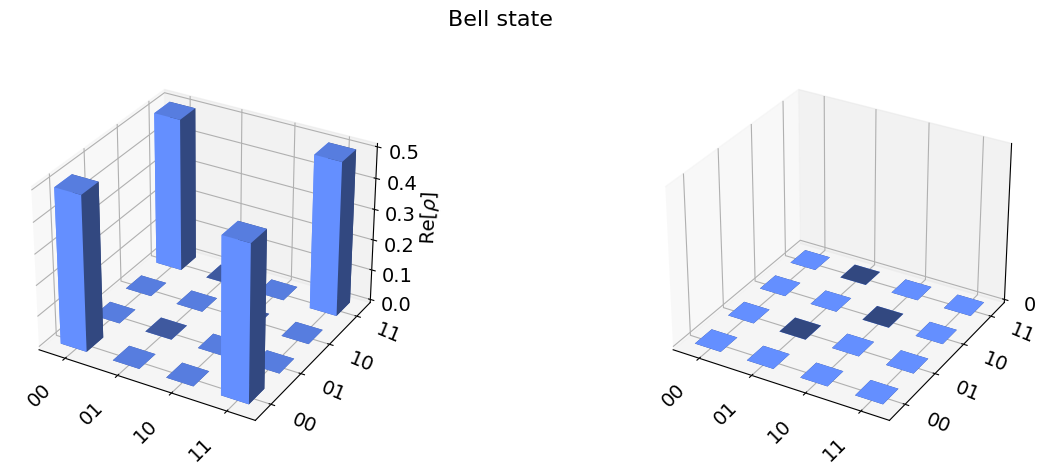

In [10]:
plot_state_city(state, title='Bell state') # State tomography of Bell state

# 2. How to use Qiskit runtime

## Background

For the last ~3-4 years, users of IBM Quantum systems have had full control of the construction, compilation, and execution of quantum circuits on these systems.  With power comes responsibility, and users are expected to know the details of how the hardware works, and how to improve their performance via error suppresion and mitigation techniques.  This makes life difficult for those not well versed in advanced quantum computing techniques.

As quantum computing matures, and users further detached from device physics gain interest, it is important to abstract as much of this knowledge away from these users, so that focus can be on building applications and algorithms.

The **Qiskit Runtime** is an execution architecture designed to abstract many of these details away from users, and give a high-fidelty managed user experience to those who prefer a more automated execution process.  Specifically, IBM Quantum knows many of the knobs that, to first-order, give best results and can be automatically set for users.  For these features, the options and code can be pushed into a cloud execution environment.

The Runtime is a collection of "primitive" quantum operations that execute in a dockerized cloud environment.  Currently there are two primitives that users can use:

| Primitive | What it does | Inputs | Outputs |
| --- | --- | --- | --- |
| **Sampler** | Samples circuit output distributions, possibly with error mitigation | Quantum circuits | Quasi-probability distributions \[distributions with (possibly) negative values, but that sums to one\] |
| **Estimator** | Computes expectation values for operators and states defined by circuits, possibly with error mitigation | Quantum circuits and operators | A list of expectation values (and error estimates) |


These represent additional access options to the `backend.run()` method used in previous sections.

In what follows, we will demonstrate how to use these primitives, and explore the benefits of abstraction, and also performance, that Runtime has to offer.

In [11]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import hellinger_fidelity
from qiskit.visualization import plot_distribution

# Operators from Qiskit
from qiskit.quantum_info import SparsePauliOp

# Import the primitives from Qiskit
from qiskit.primitives import Sampler, Estimator

# Import simulator primtives from Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator

## Basics of Runtime

### Builtin Qiskit primitives

Qiskit itself has interfaces for working with the `Sampler` and `Estimator` primitives without accessing hardware. First, lets execute our good friend the BV circuit using the Sampler:

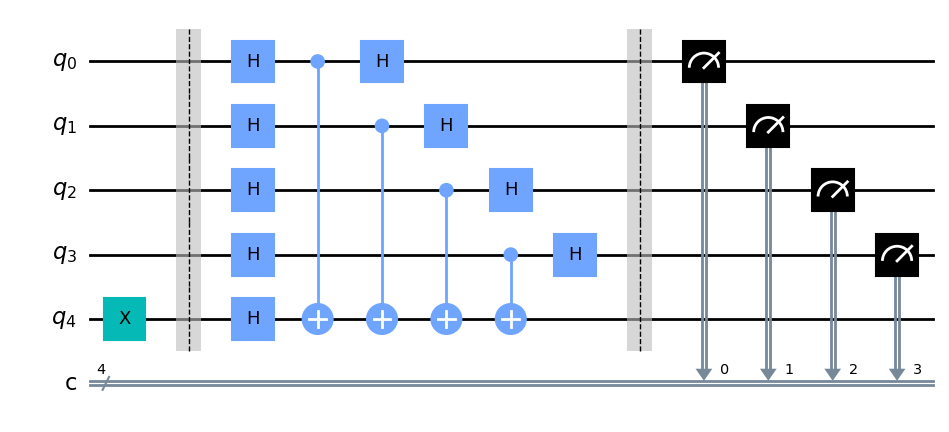

In [12]:
def bv_ones_circs(N, measurements=True):
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.barrier()
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    if measurements:
        qc.measure(range(N-1), range(N-1))
    
    return qc

N = 5
qc = bv_ones_circs(N)
qc.draw('mpl')

First, we need to instantiate an instance of the `Sampler`

In [13]:
sampler = Sampler()

The `sampler` can be used much like `backend.run()` where circuits are passed, and a job instance with results is returned:

In [16]:
res = sampler.run(qc).result()
res

SamplerResult(quasi_dists=[{15: 0.9999999999999986}], metadata=[{}])

The output quasi-distribution is contained in the `result.quasi_dists` attribute.

In [17]:
res.quasi_dists

[{15: 0.9999999999999986}]

Unlike the usual `Counts` returned via `backend.run()` the quasi-distribution states are given as integers rather than bit-strings, and the values are not discrete counts.  This is because, as the number of qubits grows, the size of the bit-string keys grows much larger than the equivilent integer representation.

We can use these quasi-distributions to do basically everything the `Counts` was used for.  e.g. we can compute fidelities:

In [18]:
hellinger_fidelity(res.quasi_dists[0], {15: 1})

1.0

alternatively one can work in bit-strings:

In [19]:
hellinger_fidelity(res.quasi_dists[0].binary_probabilities(), {'1'*(N-1): 1})

1.0

We can also plot the results.  It is best to do so with the new `plot_distribution` function since our data is not discrete

In [20]:
res.quasi_dists[0].binary_probabilities()

{'1111': 0.9999999999999986}

In [21]:
original_probs = res.quasi_dists[0].binary_probabilities()

# Define a list of all possible states and their probabilities
all_states = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
quasi_probs = {state: original_probs.get(state, 0) for state in all_states}

# Extract the probabilities and states

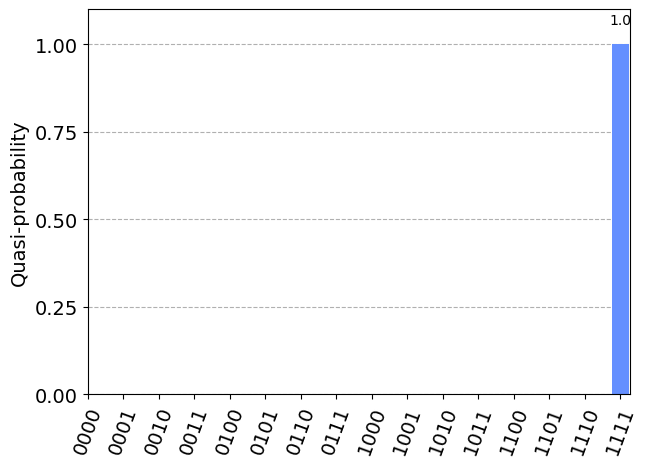

In [22]:
plot_distribution(quasi_probs)

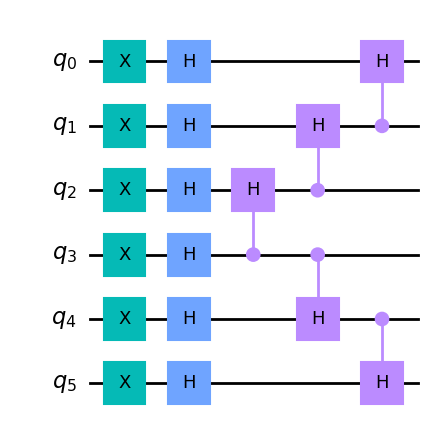

In [24]:
def cntrl_hadamard_ladder(N, measurements=False):
    qc = QuantumCircuit(N)

    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    if measurements:
        qc.measure_all()
    return qc

N = 6
qc2 = cntrl_hadamard_ladder(N) 
qc2.draw('mpl')

In [26]:
estimator = Estimator()
oper = SparsePauliOp.from_list([('Z'*6, 1)])
est_res = estimator.run(qc2, oper).result()
est_res.values[0]

0.4374999999999992

## Using Runtime with IBM Quantum systems

To get access to IBM Quantum systems via the Runtime execution environment we need to create a service object from the `qiskit_ibm_runtime` package:

<div class="alert alert-warning">
    This notebook is requires installing the <tt>qiskit-ibm-runtime</tt>:
    <ul>
        <li>IBM Qiskit Runtime: <tt>pip install qiskit-ibm-runtime</tt></li>
    </ul>
</div>

In [27]:
# The IBM Quantum Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Estimator, Session, Options

c:\Users\c5517\python\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: eet is an invalid version and will not be supported in a future release
  warnings.warn(


In [28]:
service = QiskitRuntimeService()

In [29]:
service.backends()

[<IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibm_nazca')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibm_algiers')>]

In [30]:
sim = service.get_backend('ibmq_qasm_simulator')

In [31]:
oper = SparsePauliOp.from_list([('Z'*4, 1)])

In [32]:
sampler = Sampler(session=sim)
estimator = Estimator(session = sim)

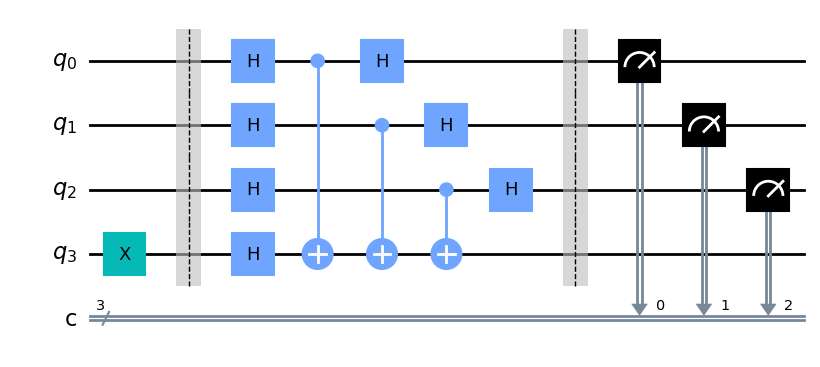

In [33]:
N = 4
qc = bv_ones_circs(N)
qc.draw('mpl')

In [34]:
samp_job = sampler.run(qc)
samp_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [35]:
samp_res = samp_job.result()
samp_res.quasi_dists[0].nearest_probability_distribution(return_distance = False), samp_res.quasi_dists

({7: 1.0}, [{7: 1.0}])

## Sessions

When creating our sampler object we passed the target backend `Sampler(session=backend)` in as a "session".  The concept of a `Session` is new, and it is a part of the IBM Quantum Runtime execution engine.  

In short, a `Session` is a "container" that holds a collection of jobs from primitives.  In general, there are two ways this works.  First, one can have a collection of one or more jbos that are independent.  Second, one can have two or more jobs that are interconnected, with later jobs conditioned on the results from those previously executed.  This latter case is typical for iterative algorithms such as variational methods.

![independent](images/runtime2/independent.png)

![related](images/runtime2/related.png)

There are a couple of ways that Sessions can be utilized.  First, and most ideal, as a session is connected to the backend on which it is run, we can directly create a session instance from such a backend object:

In [36]:
session = Session(backend=sim)

we can then create a primitive instance using this `session`:

In [37]:
sampler = Sampler(session=session)

or we can do what we did above and just use the backend directly:

In [38]:
sampler = Sampler(session=sim)

Alternatively, we can use Python contexts and have the session setup automatically within the confines of a `with`-block:

In [39]:
with Session(backend=sim):
    sampler = Sampler()
    job = sampler.run(qc)
    print(job.result())

SamplerResult(quasi_dists=[{7: 1.0}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])


In [41]:
session = Session(backend=sim)

estimator = Estimator(session=session)

job2 = estimator.run(qc, oper)

print(job2.result().values)

[-0.0405]


In [42]:
options = Options(optimization_level=2, shots=1234)

or we can use autocomplete.  For example, let us turn off Runtime transpilation altogether and change the shots

In [43]:
options = Options()

In [44]:
options.transpilation.skip_transpilation = True
options.execution.shots = 54321

To see a list of all the options can just look at the `Options` class:

In [45]:
options

Options(optimization_level=None, resilience_level=None, max_execution_time=None, transpilation=TranspilationOptions(skip_transpilation=True, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None), resilience=ResilienceOptions(noise_amplifier=None, noise_factors=None, extrapolator=None), execution=ExecutionOptions(shots=54321, init_qubits=True), environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None))

We can set the options for each primitive when we create it:

In [46]:
with Session(backend=sim):
    sampler = Sampler(options=options)
    job1 = sampler.run(qc)

In [47]:
job1.result().metadata[0]['shots']

54321

## Hands on example: CHSH via Runtime

### Background

<img src="images/runtime2/people.png"/>

Alain Aspect, John Clauser and Anton Zeilinger </figcaption>

This years Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger, for their pioneering work in quantum information science, and in particular their experiments with entangled photons demonstrating violation of Bell’s inequalities.  An experimental method by which one can test Bell's inequality was put forth by [Clauser, Horne, Shimony, and Holt (CHSH) in 1969](https://doi.org/10.1103/PhysRevLett.23.880).  A few years later polarization correlations in photon pairs from Calcium atoms was observed: [Stuart J. Freedman and John F. Clauser
Phys. Rev. Lett. 28, 938 (1972)](https://doi.org/10.1103/PhysRevLett.28.938), although this experiment suffered from a number of loopholes.  These loopholes were removed in subsequent works by [Aspect et al](https://doi.org/10.1103/PhysRevLett.49.91) and [Zeilinger et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.81.5039).

Of particular interest is the "locality" loophole, where measurements of each photon in an entangled pair must be space-like separated; there is no classical signal that could be sent at the speed of light from one detector to the other to influence the detection process.  On a superconducting processor such as those from IBM Quantum, there is no way around the locality loophole any time in the near future as the distances on super conducting chips is of the order of centimeters, and the speed of light (even in metal) is tens of millions of meters per second.  However, for demonstration purposes, lets try to generate CHSH violations on IBM Quantum systems and reproduce Nobel Prize winning work.

### Setup

CHSH violations are generated by looking at expectation values of measurements on two qubits prepared in a Bell state, where the basis of one qubit is varied relative to the other.  So first we need a Bell state:

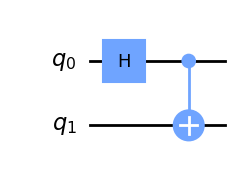

In [48]:
bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0, 1)
bell_state.draw('mpl')

and second, we need create measurement circuits that measure in the bases: `ZZ`, `ZX`, `XZ` and `ZZ`.  Additionally, we will apply a parameterized `ry` to qubit 0 that varies the realtive difference between the two basis measurements (this is not strictly needed, but makes for nice plots)

In [49]:
from qiskit.circuit import Parameter
# Circuit order is ZZ, ZX, XZ, XX
theta = Parameter('$\\theta$')
meas_circuits = []
for basis in ['ZZ', 'ZX', 'XZ', 'XX']:
    qc = QuantumCircuit(2)
    qc.ry(theta, 0)
    for idx, oper in enumerate(basis[::-1]):
        if oper == 'X':
            qc.h(idx)
    qc.measure_all()
    meas_circuits.append(qc)

the measurement circuits are thus:

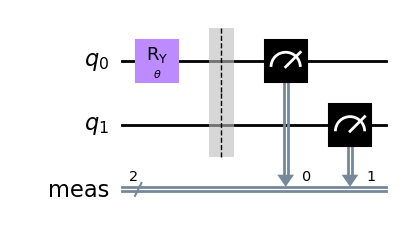

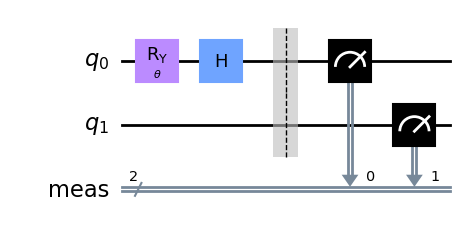

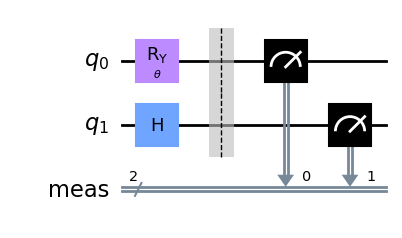

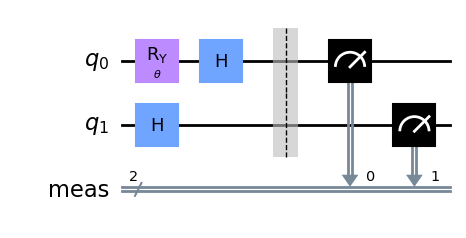

In [50]:
for circ in meas_circuits:
    display(circ.draw('mpl'))

Now we need to set the values for the parameter $\theta$ that we want to sweep over:

In [75]:
# Select phases from [0, 2pi]
num_phases = 21
phase_array = np.linspace(0, 2*np.pi, num_phases)
# Format for parameter binding
phases = [[ph] for ph in phase_array]

Now lets make a collection of 4 circuits by composing the measurement circuits onto the Bell state

In [76]:
chsh_with_meas = [bell_state.compose(circ) for circ in meas_circuits]

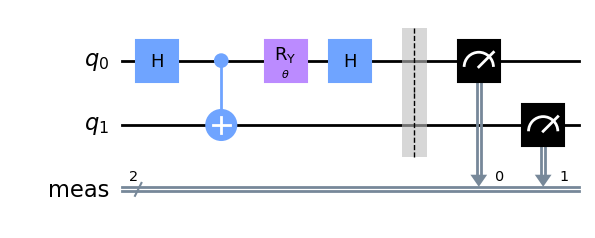

In [77]:
chsh_with_meas[1].draw('mpl')

Now, when it comes to binding parameters in Runtime, we have some options.  Here I am going to bind the circuits ahead of time since I will demo the output without using Runtime:

In [78]:
bound_circs = []
for circ in chsh_with_meas:
    bound_circs.extend([circ.bind_parameters(ph) for ph in phases])

We are now in a position to simulate our circuits:

In [79]:
aer_sim = AerSimulator()

In [80]:
counts = aer_sim.run(bound_circs, shots=int(1e4)).result().get_counts()

collect the counts over all $\theta$ values for each circuit

In [81]:
res = [counts[kk*num_phases:num_phases*(kk+1)] for kk in range(4)]

and compute the ZZ expectation values (we applied post-rotations) for each value of $\theta$

In [82]:
from qiskit.result import sampled_expectation_value
# Compute ZZ expectaion values for circ ZZ at each phase angle, 
# ZX at each phase angle, etc...
arrs = [np.array([sampled_expectation_value(cnts, 'ZZ') for cnts in item]) for item in res]

There are two-inequalities that can be formed from the returned expectation values:

In [83]:
#Compute CHSH for each value of theta requested
chsh1 = arrs[0]-arrs[1]+arrs[2]+arrs[3]
chsh2 = arrs[0]+arrs[1]-arrs[2]+arrs[3]

A CHSH violation occurs when the magnitude of these CHSH values is $>2$, and is a validation of Bell's theorem; quantum mechanics cannot be desribed by local hidden variables.

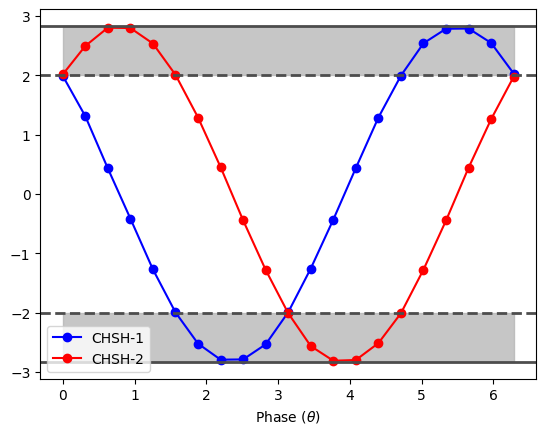

In [84]:
fig, ax = plt.subplots()
ax.plot(phase_array, chsh1, 'bo-',label='CHSH-1')
ax.plot(phase_array, chsh2, 'ro-', label='CHSH-2')
ax.axhline(2, linestyle='dashed', lw=2, zorder=2, color='0.3')
ax.axhline(2*np.sqrt(2), linestyle='solid', lw=2, zorder=2, color='0.3')
ax.axhline(-2, linestyle='dashed', lw=2, zorder=2, color='0.3')
ax.axhline(-2*np.sqrt(2), linestyle='solid', lw=2, zorder=2, color='0.3')
ax.fill_between(phase_array, 2, 2*np.sqrt(2), color='0.7', alpha=0.75, zorder=1)
ax.fill_between(phase_array, -2, -2*np.sqrt(2), color='0.7', alpha=0.75, zorder=1)
ax.set_xlabel('Phase ($\\theta$)')
ax.legend();

# Mesurement error mitigation

## Overview

On superconducting platforms such as IBM Quantum systems, measurements have one of the highest (it not the highest) error rate per operation of any instruction.  Although quantum circuits often contain many more gates than measurements, the output of a quantum computer relies on qubit measurement, making the correction of these operations an important task for achieving high-fidelity results.  Fortunately, techniques have been developed that make mitigating these errors, on average, computationally feasible.  However, as with all mitigation methods, the cost is an increase in the variance of the computed observables; requiring an increase in the number of circuit executions needed for recovering the initial variance.  Here we will look at the "M3" method that the Runtime uses to mitigate errors in the `Sampler` primitive.

- M3 Paper: [PRX Quantum 2, 040326 (2021)](https://doi.org/10.1103/PRXQuantum.2.040326)

## Setup

In [85]:
# Standard imports
import numpy as np
from qiskit import *

# Load stuff needed for this notebook
from qiskit.quantum_info import Statevector, hellinger_fidelity
from qiskit.providers.fake_provider import FakeProvider
from qiskit.result import sampled_expectation_value

# IBM Quantum Runtime account and primitives
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Plotting stuff to look better
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
try:
    plt.style.use('quantum-light')
except: pass

Lets load our IBM Quantum account and grab a real system:

In [86]:
service = QiskitRuntimeService()

In [87]:
backend = service.get_backend('ibmq_qasm_simulator')

In [88]:
from qiskit_aer.noise import NoiseModel
noisy_backend = service.get_backend('ibm_brisbane')
backend_noise_model = NoiseModel.from_backend(noisy_backend)
coupling_map = noisy_backend.configuration().coupling_map
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": coupling_map,
    'seed_simulator': 6322
}

In [89]:
backend_noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '99b649e670fd4d8ab150759d38411adc',
   'operations': ['id'],
   'instructions': [[{'name': 'id', 'qubits': [0]}],
    [{'name': 'z', 'qubits': [0]}],
    [{'name': 'reset', 'qubits': [0]}]],
   'probabilities': [0.9995520217889429,
    0.0002501817340864534,
    0.000197796476970713],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': '01fdffa2a5d5452e94819284e247ecdc',
   'operations': ['id'],
   'instructions': [[{'name': 'id', 'qubits': [0]},
     {'name': 'id', 'qubits': [0]}],
    [{'name': 'id', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}],
    [{'name': 'id', 'qubits': [0]}, {'name': 'reset', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}, {'name': 'id', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}, {'name': 'reset', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}, {'name': 'id', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}, {'name': 'z', 'qubits': 

In [90]:
sampler = Sampler(backend, options=options)

## Background

Although the power of quantum computation lies in the ability to create large amounts of entanglement and explore large swaths of Hilbert space, at the end of the day the result encoded in the terminal quantum state must be converted to classical information by measuring the qubits.  Note that there is also the possibility of mid-circuit measurements, but we will not address those here.

When measureing a qubit, there are two error rates that quantify the noise:

- $P_{10}$: Probability of qubit in the $0$ state but measuring $1$.

- $P_{01}$: Probability of qubit in the $1$ state but measuring $0$.

The probabilities of correctly measuring the qubit in the 0 and 1 states are thus $P_{00}=1-P_{10}$ and $P_{11}=1-P_{01}$, respectively.

In [91]:
props = noisy_backend.properties()

In [92]:
P01 = props.qubit_property(0, 'prob_meas0_prep1')[0]
P10 = props.qubit_property(0, 'prob_meas1_prep0')[0]

Assuming the measurement error for each qubit is uncorrelated with that of other qubits, we can define an Assignment, "A-matrix", for each qubit:

In [93]:
# Build the "Assignment" matrix
A0 = np.array([[1-P10, P01],
               [P10, 1-P01]])
A0

array([[0.9796, 0.0414],
       [0.0204, 0.9586]])

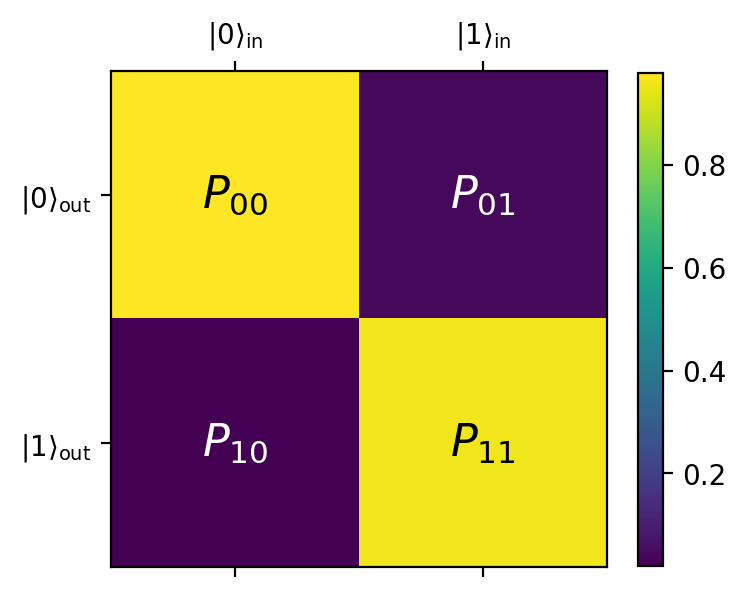

In [94]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.matshow(A0)
ax.grid(False)
# Coordinates for annotations are (x,y) NOT matrix (row, col)
ax.annotate('$P_{00}$', (0,0), fontsize=16, ha='center', va='center')
ax.annotate('$P_{11}$', (1,1), fontsize=16, ha='center', va='center')
ax.annotate('$P_{01}$', (1,0), fontsize=16, ha='center', va='center', color='white')
ax.annotate('$P_{10}$', (0,1), fontsize=16, ha='center', va='center', color='white')
ax.set_xticks([0, 1])
ax.set_xticklabels(['$|0\\rangle_{\\rm in}$', '$|1\\rangle_{\\rm in}$'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['$|0\\rangle_{\\rm out}$', '$|1\\rangle_{\\rm out}$'])
fig.colorbar(im, shrink=0.8);

The interpretation of the A-matrix is as follows.  The column indices label the target bit-string state, while the row indicates what you actually got in your experiment.  Thus we see that the matrix elements $P_{ij}$ tell us the probability of starting in state $j$, but ending up in state $i$.  Typically $P_{01} > P_{10}$ because relaxation of the $|1\rangle$ state to the $|0\rangle$ is the dominante source of error. Notice that the sum over all the elements of each column is `1`; an input bit-string has to go somehwere.

The average of the two error rates, $P_{01}$ and $P_{10}$, is called the ``readout_error`` and it is also reported by the backend for each qubit:

In [95]:
props.qubit_property(0, 'readout_error')

(0.030899999999999928,
 datetime.datetime(2023, 11, 8, 14, 34, 5, tzinfo=tzlocal()))

Lets take a look at the distribution of these values over a full system:

In [96]:
meas_errors = [props.qubit_property(qubit, 'readout_error')[0] 
               for qubit in range(backend.configuration().num_qubits)]

print('Median:', np.median(meas_errors))
print('Mean:', np.mean(meas_errors))

Median: 0.014400000000000024
Mean: 0.020428125000000002


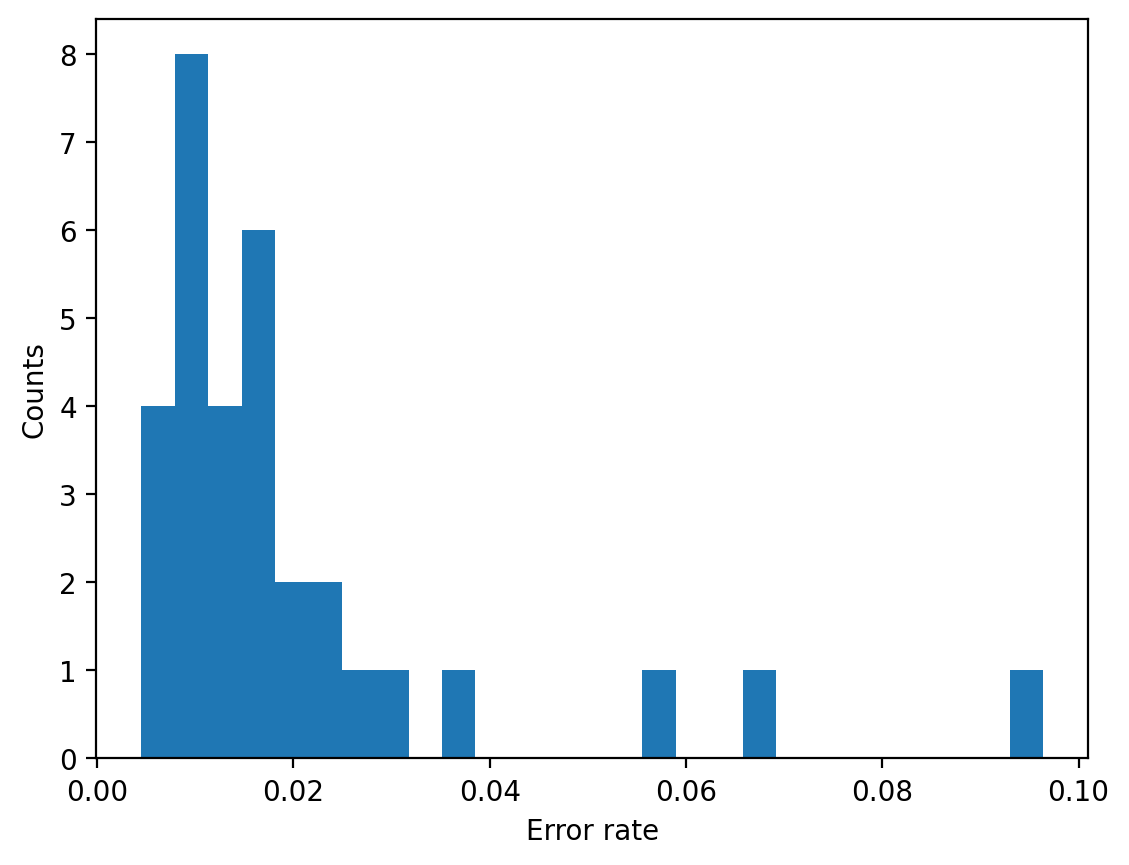

In [97]:
fig, ax = plt.subplots()
ax.hist(meas_errors, bins=27)
ax.set_xlabel('Error rate');
ax.set_ylabel('Counts');

We see that the error rates can vary by and order of magnitude over a quantum chip.  Therefore qubit selection and ultimately readout mitigation is needed to reduce the impact of measurement imperfections.  How to do this is the topic of the next section.

## Mitigating measurement errors

The A-matrix leads us to a very simple linear expression for how measurement errors affect our output probability distribution:

$$
\vec{p}_{\rm exp} = A\vec{p}_{\rm ideal}
$$

where $\vec{p}_{\rm ideal}$ is a vector representation of the ideal distribution (including gate errors) over all computational basis states, and $\vec{p}_{\rm exp}$ is the actual distribution we measured in the experiment.  This equation is valid for not just a single qubit, but any number of measured qubits, but the dimensionality of the full linear system of equations grows exponentially in the number of qubits.  Assuming readout out errors are independent, the full A-matrix takes the form:  $A=A_{n-1}\otimes\dots\otimes A_{1}\otimes A_{0}$ 

The equation above is a linear equation of the form $A\vec{x}=\vec{b}$, where we are solving for the unknown vector $\vec{x}=\vec{p}_{\rm ideal}$.  Let try solving it for a very simple example:

In [98]:
qc = QuantumCircuit(1)
qc.x(0)
qc.measure_all()

# Here we are using "seed_simulator" to fix the output
probs = sampler.run(qc, shots=1e4, seed_simulator=12345).result().quasi_dists[0]
probs

{0: 0.0007890135198532877, 1: 0.9992109864801467}

Need to convert our dictionary to an array:

In [99]:
probs_vec = np.array([probs.get(0, 0), probs.get(1, 0)], dtype=float)
probs_vec

array([7.89013520e-04, 9.99210986e-01])

In [101]:
np.linalg.solve(A0, probs_vec)

array([-0.04328607,  1.04328607])

After running the above code you should see that the probability of getting `'1'` is nearly 1.0.  In fact it can be even larger than 1, with a negative probability for being found in the `'0'` state!  This is not an error or bug, but rather a consequence of the fact that there are fluctuations in sampling statistics that can lead to over- or under-correction.  The output from measurement mitigation is a wider class of distibutions known as quasi-probability distributions; Distributions that can contain negative values, but never the less sum up to one.  This fact raises an important limitation on what we can do with these distributions; **Quasi-probability distributions can only be directly used to compute expectation values of observables or finding the most probable bit-string**.  They cannot be used, for example, for computing the fidelity of the result against a known answer.

## Measurement mitigation with M3

Given the realatively high error rates of measurements on superconducting processors, we would like to suppress these errors as much as possible.  Now, we could naively find the A-matrix corresponding to each measured qubit and take the tensor product of them all.  However, this leads to a $2^{N}\times 2^{N}$ matrix that is tractible for only a small number of qubits, e.g. $\lesssim 18$.  In order to correct large numbers of qubits we need to be a bit smarter than this. 

The M3 (**M**atrix-free **M**easurement **Mitigation**) is one example that looks at the problem in a different way.

<img src="images/meas_mitigation/m3_truncation.png"/>

Namely, M3 considers the fact that, when measurement errors are small, the effect is to take small amounts of probability away from the correct output bit-strings and move them to erroneous bit-strings that are close in terms of Hamming distance.  Because the errors are weak, with sufficient sampling, it is unlikely that an ideal bit-string is completely redistributed; the correct answer is a subset of the noisy output.  This insight indicates that we can truncate the full A-matrix into one that has a dimension that is equal to the number of unique bit-strings in the output.  This equation is typically much much smaller than the full A-matrix, and thus easier to solve, e.g. via LU decomposition or iterative methods.

M3 measurement mitigation can be broken into 3 steps:

1. Construct a mitigator targeting a backend (`backend`).

2. Use the mitigator `mit` to calibrate over a list of physical qubits (`qubits`) measured

3. Generate a corrected set of quasiprobabilities from a given set of noisy counts data

We can then use these quasiprobabilities to evaluate problems such as those for sampling algorithms, which is why it is in the `Sampler`, and / or algorithms that compute expectation values (but in the Runtime, that is a different method).

## Example

To begin, let us consider our usual all-ones BV circuit:

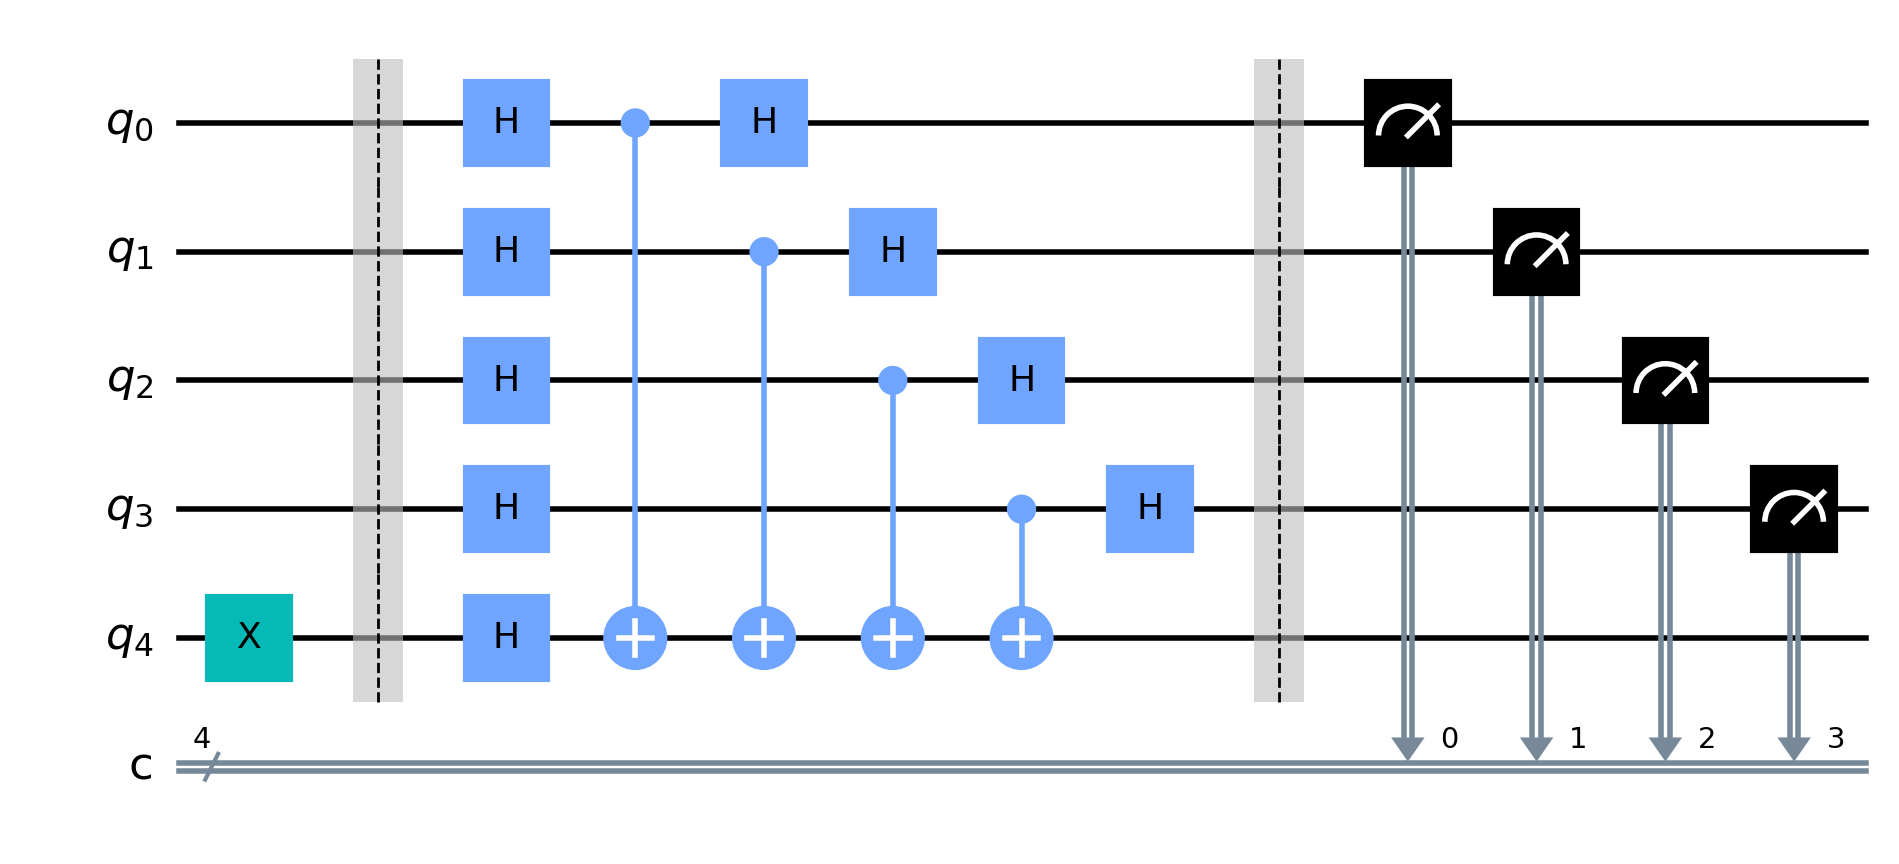

In [103]:
def bv_ones_circs(N):
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.barrier()
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    qc.measure(range(N-1), range(N-1))
    return qc

N = 5
bv_circ = bv_ones_circs(N)
bv_circ.draw('mpl')

We want to see how performing readout-mitigation improves the probability of getting the all-ones bit-string.  Here we will use `resilence_level`, which controls how much mitigation is applied to the result.  The default `resilence_level=1` uses readout mitigation, so lets first turn it off:

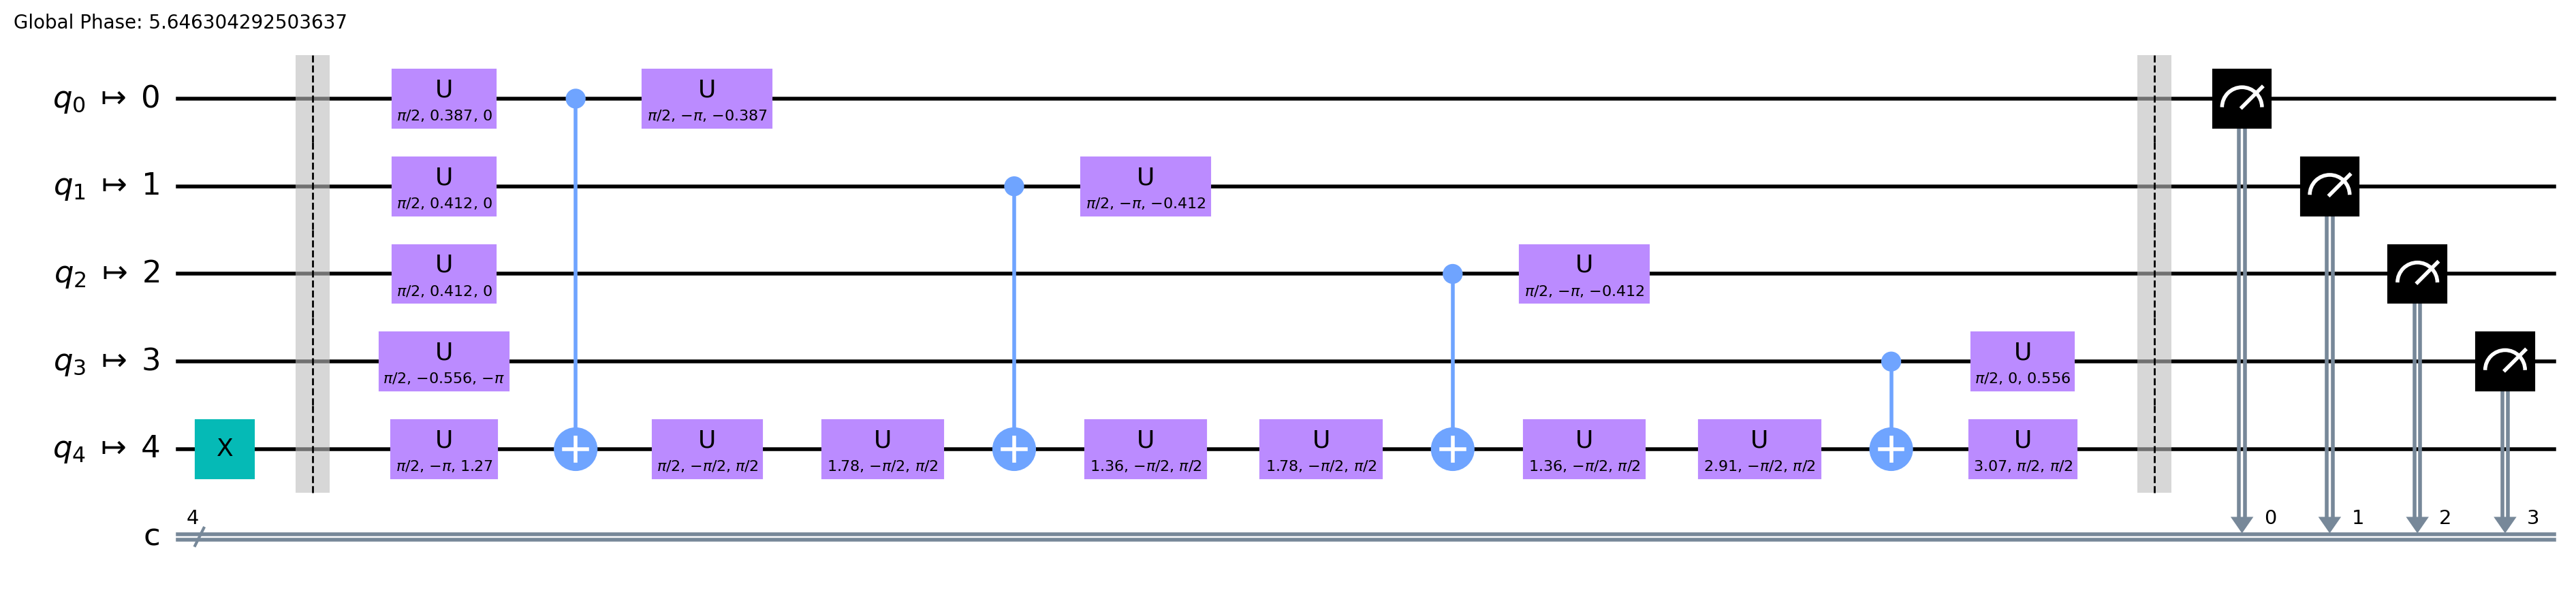

In [116]:
q_layout = [0, 1, 2, 3, 4]
circ = transpile(bv_circ, backend=backend, initial_layout=q_layout, seed_transpiler= 1234, optimization_level=3)
circ.draw('mpl',idle_wires=False,fold=30)

In [108]:
no_mit_probs = sampler.run(circ, shots=int(1e4), resilience_level=0).result()

The success rate is found to be:

In [109]:
no_mit_probs.quasi_dists[0][15]

0.9373

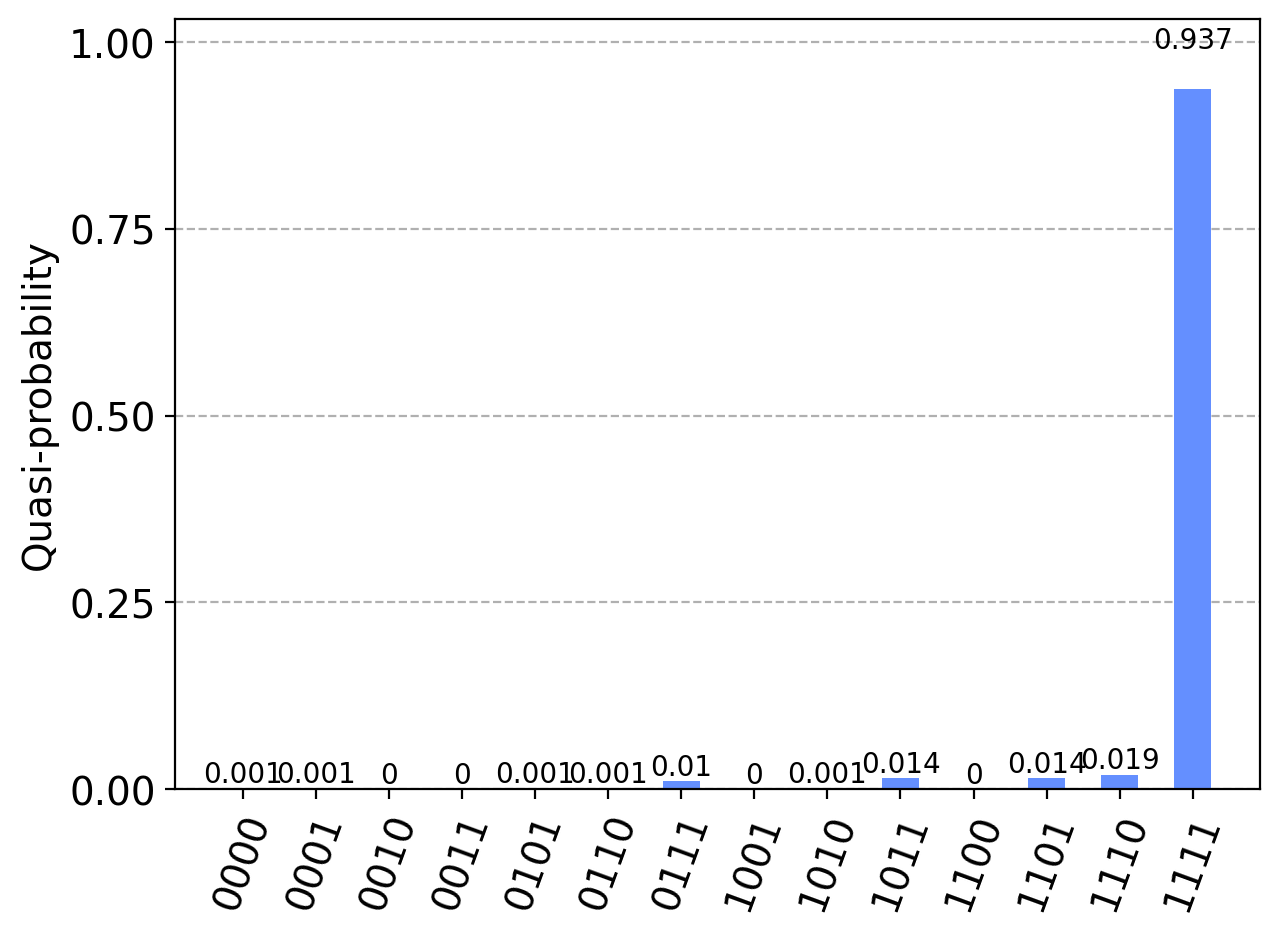

In [110]:
plot_distribution(no_mit_probs.quasi_dists[0].binary_probabilities())

We can now turn the `resilience_level` back to its default value and see what happens:

In [111]:
mit_probs = sampler.run(circ, shots=int(1e4), resilience_level=1,skip_transpilation=True).result()

In [112]:
mit_probs.quasi_dists[0][15]

1.0071440475713827

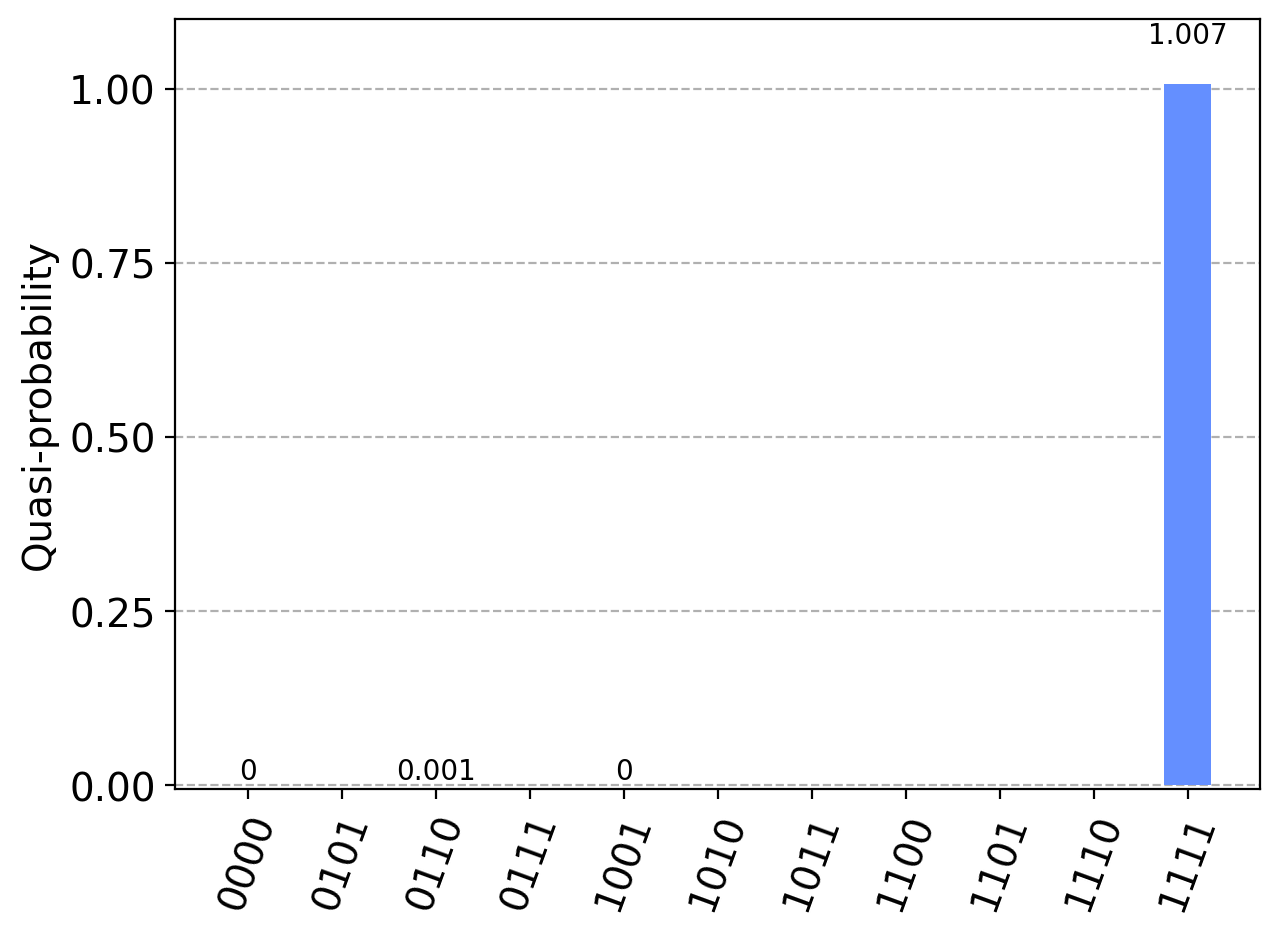

In [114]:
plot_distribution(mit_probs.quasi_dists[0].binary_probabilities())